In [1]:
import numpy as np
import glob
import cv2 as cv
import json
import math
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import pickle
import glob
import tqdm
import os
import seaborn as sns

In [6]:
name_to_resize = dict()
for file in tqdm.tqdm(sorted(glob.glob("../segmentation/full_maps/other_full_predictions/*.png"))):
    image = cv.imread(file)
    image_width, image_height = image.shape[1], image.shape[0]
    image_scale = max(image_height, image_width)/1400
    small = cv.resize(image, (0,0), fx=1/image_scale, fy=1/image_scale)
    file = file[len("../segmentation/full_maps/other_full_predictions/"):-4]
    name_to_resize[file] = image_scale
    skeleton = skeletonize(small)
    cv.imwrite(f"assets/other_map_skeleton/{file}.png", skeleton)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


In [7]:
baseline_height = 7748
baseline_width = 9877

In [15]:
def do_superglue(resize, nms_radius):
    max_keypoints = -1
    
    #!python ./match_pairs.py --superglue outdoor --resize $resize --max_keypoints $max_keypoints --nms_radius $nms_radius  --resize_float --input_dir assets/other_map_skeleton --input_pairs assets/other_map.txt --output_dir other_superglue_output --viz
    good_maps = []
    for npz_file in tqdm.tqdm(sorted(glob.glob("other_superglue_output/*.npz"))):
        map_name = npz_file[npz_file.find("\\")+1:npz_file.find("baseline")-1]
        baseline_name = npz_file[npz_file.find("baseline"):-12]
        image_scale = name_to_resize[map_name]
        baseline_scale =  name_to_resize[baseline_name]
        npz = np.load(npz_file)

        src_pts = []
        dst_pts = []
        for i in range(len(npz["matches"])):
            if npz["matches"][i] != -1 :
                src_pts.append(npz["keypoints0"][i]*(image_scale))
                dst_pts.append(npz["keypoints1"][npz["matches"][i]]*(baseline_scale))
        src_pts = np.array(src_pts).reshape(-1,1,2)
        dst_pts = np.array(dst_pts).reshape(-1,1,2)

        try:
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            good_maps.append((map_name, baseline_name, M))
        except:
            continue

    return good_maps 

In [3]:
def do_superglue_with_validation(resize, nms_radius):
    max_keypoints = -1
    baseline_scale =  max(baseline_width, baseline_height) /  resize
    #!python ./match_pairs.py --superglue outdoor --resize $resize --max_keypoints $max_keypoints --nms_radius $nms_radius  --resize_float --input_dir assets/map_test_skeleton/ --input_pairs assets/map_test_skeleton/val_map.txt --output_dir superglue_output
    distances = []
    well_referenced = 0
    badly_referenced = 0
    good_maps = []
    baseline = cv.imread('assets/map_test_skeleton/baseline.png')
    print(baseline.shape)
    for npz_file in glob.glob("superglue_output/*.npz"):
        map_name = npz_file[npz_file.find("/")+1:-21]
        with open(f"assets/points_transformed/{map_name}.json", "r") as test_points_json:
            test_points = json.load(test_points_json)
            image_scale = max(test_points["image_height"], test_points["image_width"])/resize
            npz = np.load(npz_file)

            src_pts = []
            dst_pts = []
            for i in range(len(npz["matches"])):
                if npz["matches"][i] != -1 :
                    src_pts.append(npz["keypoints0"][i]*(image_scale))
                    dst_pts.append(npz["keypoints1"][npz["matches"][i]]*(baseline_scale))
            src_pts = np.array(src_pts).reshape(-1,1,2)
            dst_pts = np.array(dst_pts).reshape(-1,1,2)

            try:
                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
            except:
                badly_referenced += 1
                continue

            pts = np.float32([[x,y] for x,y in zip(test_points["x"], test_points["y"])]).reshape(-1,1,2)
            targets = np.float32([[x,y] for x,y in zip(test_points["x_"], test_points["y_"])])
            try:
                p_transformed = cv.perspectiveTransform(pts,M).reshape(-1,2)
            except:
                badly_referenced +=1
                continue
            

            dst = [math.sqrt((target_x - p_transformed_x)**2 + (target_y - p_transformed_y)**2) for ((target_x, target_y), (p_transformed_x, p_transformed_y)) in zip (targets, p_transformed)]
            distance = np.mean(dst)
            distances+=dst
            
            if distance < 100:
                well_referenced += 1
                good_maps.append((map_name,M,distance))
            else:
                badly_referenced += 1

    return distances, well_referenced, good_maps 

In [16]:
superglue_results = do_superglue(1400,5)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:40<00:00,  1.68s/it]


In [17]:
superglue_results

[('btv1b10223757q_f1',
  'baseline_strasbourg',
  array([[ 8.46246058e-01,  3.01072072e-02,  1.61554056e+03],
         [-1.76817733e-02,  8.38417670e-01,  2.10309131e+03],
         [ 1.53569268e-06,  2.07255336e-07,  1.00000000e+00]])),
 ('btv1b10223975d_f1',
  'baseline_strasbourg',
  array([[ 8.02923946e-01,  1.71392122e-02,  3.17345137e+02],
         [-3.86718235e-02,  7.82882139e-01,  6.49921125e+02],
         [-3.92031440e-07, -7.52383031e-06,  1.00000000e+00]])),
 ('btv1b10678312p_f1',
  'baseline_montpellier',
  array([[ 4.43693101e-01, -2.68154951e-02,  2.48178395e+02],
         [ 1.06256198e-02,  4.23005558e-01, -5.57893352e+02],
         [ 1.87886779e-06, -1.07212670e-05,  1.00000000e+00]])),
 ('btv1b53019759c_f1',
  'baseline_strasbourg',
  array([[ 8.77061888e-01,  9.09788673e-02,  1.68350736e+03],
         [-3.13052817e-02,  8.99552551e-01,  1.80199583e+03],
         [ 1.59360871e-06,  7.48349004e-06,  1.00000000e+00]])),
 ('btv1b53025244r_f1',
  'baseline_rome',
  array([

In [49]:
d = [x*1.19 for x in superglue_results[0]]

In [51]:
with open('superglue_distances.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

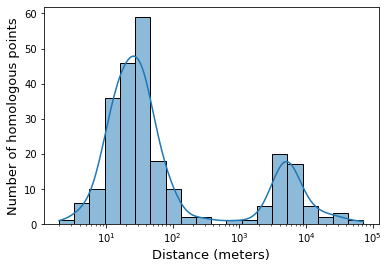

In [50]:
f, ax = plt.subplots(figsize=(6, 4))
ax.set(xscale="log")
sns.histplot(data=d, ax=ax, bins=20, kde=True, kde_kws={"bw_adjust":0.5})
ax.set_ylabel("Number of homologous points", fontsize=13)
ax.set_xlabel("Distance (meters)", fontsize=13)
ax.get_figure().savefig("superglue_results.png")

In [67]:
with open('other_maps_results.pickle', 'wb') as handle:
    pickle.dump(superglue_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('homographies.pickle', 'rb') as handle:
    superglue_results = pickle.load(handle)

In [20]:
for map_name, baseline_name, M in tqdm.tqdm(superglue_results):
    try:
        baseline = cv.imread(f"../segmentation/full_maps/other_full_predictions/{baseline_name}.png", cv.IMREAD_GRAYSCALE)
        baseline = skeletonize(baseline/255).astype(np.uint8)*255
        map_image = cv.imread(f"../segmentation/full_maps/other_full_predictions/{map_name}.png", cv.IMREAD_GRAYSCALE)
        map_image = cv.warpPerspective(map_image,M,(baseline.shape[1], baseline.shape[0]))
        map_image = skeletonize(map_image/255).astype(np.uint8)*255
        cv.imwrite(f"assets/other_warped_maps/{map_name}.png", map_image)
    except:
        continue


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [16:40<00:00, 43.50s/it]


In [5]:
baseline = cv.imread("assets/map_test/baseline.png", cv.IMREAD_GRAYSCALE)
baseline = skeletonize(baseline/255).astype(np.uint8)*255
cv.imwrite(f"assets/warped_maps/baseline.png", baseline)

True